# Flights Data Exploration
## by Daiki Kudo

## Preliminary Wrangling

> This document explores a dataset containing approximately 7 million records of flight data in 2008.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import timeit
import glob
pd.set_option('display.max_columns', 500)

%matplotlib inline

In [3]:
# load in the dataset into pandas dataframe
df_2008 = pd.read_csv("2008.csv", dtype={'DepTime':str, "CRSDepTime":str, "ArrTime":str, "CRSArrTime":str})

In [4]:
# high-level overview of data shape and composition
df =df_2008.copy()
print(df.shape)
print(df.info(null_counts=True))
df.head()

(7009728, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 7009728 non-null int64
Month                7009728 non-null int64
DayofMonth           7009728 non-null int64
DayOfWeek            7009728 non-null int64
DepTime              6873482 non-null object
CRSDepTime           7009728 non-null object
ArrTime              6858079 non-null object
CRSArrTime           7009728 non-null object
UniqueCarrier        7009728 non-null object
FlightNum            7009728 non-null int64
TailNum              6926363 non-null object
ActualElapsedTime    6855029 non-null float64
CRSElapsedTime       7008884 non-null float64
AirTime              6855029 non-null float64
ArrDelay             6855029 non-null float64
DepDelay             6873482 non-null float64
Origin               7009728 non-null object
Dest                 7009728 non-null object
Distance             7009728 non-null int64
TaxiIn             

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003,1955,2211,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754,735,1002,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628,620,804,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926,930,1054,1100,WN,1746,N612SW,88.0,90.0,78.0,-6.0,-4.0,IND,BWI,515,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829,1755,1959,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


> Ther are some points I have to take care in this data.
* Duplicsted rows should be deleted.
* Flights data rows which are neither cancelled nor diverted should be extracted.(These columns has null values in some Time columns)
* Date(y,m,d) column should created.
* It would be more convinient if there is a column "delay_elapsed" which is a delay time calculated from "ActualElapsedTime" - "CRSElapsedTime". 
* NaN in "CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay" shoud be replaced with 0.

In [5]:
# delete duplicsted rows  
print(df.duplicated().sum())
df = df.drop_duplicates()

4


> ArrDelay seems to have NaN when the flight is cancelled or diverted.  
In this analysis, I am focusing only on delay, so I will remove these rows of cancelled or diverted data.
Check there is not a row which has NaN in AirTime column even though it is neither cancelled nor diverted.

In [6]:
# extract rows which are neither cancelled nor diverted
df = df[(df.Cancelled==0) & (df.Diverted==0)]
print(df.Cancelled.value_counts())
print(df.Diverted.value_counts())
df = df.drop(columns=["Cancelled","Diverted","CancellationCode"])

0    6855025
Name: Cancelled, dtype: int64
0    6855025
Name: Diverted, dtype: int64


>  O.K.  
Then, I would make the "date" column which tells the date of the flight (y-m-d).  

>It is the best that DepTime, CRSDepTime, ArrTime, CRSArrTime can be converted into datestamp type.   
However, it can be the next day of "DayofMonth" (when the flight is at middle night.)  
So, I just convert them into int and confirm that they are in the appropriate range.  


In [9]:
#  add a column "delay_elapsed"

df["delay_elapsed"] = df.ActualElapsedTime - df.CRSElapsedTime
df.head(1)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,date,delay_elapsed
0,2008,1,3,4,2003,1955,2211,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,NaN,NaN,NaN,NaN,NaN,2008-01-03,-22.0


In [10]:
# confiem that ArrDelay = DepDelay + delay_elapsed (allow erros within 3 minutes)

assert df[(df.ArrDelay - df.DepDelay - df.delay_elapsed < -3) + (df.ArrDelay - df.DepDelay - df.delay_elapsed > 3) != 0].shape[0] == 0

/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [11]:
# replace NaN with 0. in "CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay"

df = df.fillna(value = {"CarrierDelay":0,"WeatherDelay":0,"NASDelay":0,"SecurityDelay":0.,"LateAircraftDelay":0})
df.sample(10)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,date,delay_elapsed
5074902,2008,9,3,3,901,905,1014,1014,US,815,N766US,73.0,69.0,45.0,0.0,-4.0,ATL,CLT,227,4.0,24.0,0.0,0.0,0.0,0.0,0.0,2008-09-03,4.0
2051375,2008,4,7,1,1737,1745,1950,2013,US,1712,N737US,133.0,148.0,119.0,-23.0,-8.0,FLL,DCA,899,4.0,10.0,0.0,0.0,0.0,0.0,0.0,2008-04-07,-15.0
2564910,2008,5,6,2,1937,1940,2009,2023,OO,4128,N806SK,92.0,103.0,73.0,-14.0,-3.0,SLC,ONT,558,5.0,14.0,0.0,0.0,0.0,0.0,0.0,2008-05-06,-11.0
351709,2008,1,22,2,903,820,1056,1017,F9,851,N939FR,113.0,117.0,96.0,39.0,43.0,DEN,PHX,602,4.0,13.0,33.0,0.0,6.0,0.0,0.0,2008-01-22,-4.0
122788,2008,1,27,7,1512,1520,1624,1635,XE,2532,N11106,72.0,75.0,56.0,-11.0,-8.0,CLE,RIC,362,5.0,11.0,0.0,0.0,0.0,0.0,0.0,2008-01-27,-3.0
4875826,2008,9,12,5,636,635,1221,1225,WN,1233,N205WN,225.0,230.0,209.0,-4.0,1.0,LAX,MDW,1750,6.0,10.0,0.0,0.0,0.0,0.0,0.0,2008-09-12,-5.0
531391,2008,1,3,4,1303,1255,1338,1332,AQ,210,N828AL,35.0,37.0,22.0,6.0,8.0,HNL,OGG,100,2.0,11.0,0.0,0.0,0.0,0.0,0.0,2008-01-03,-2.0
4168091,2008,7,8,2,1348,1345,1651,1710,B6,87,N607JB,303.0,325.0,262.0,-19.0,3.0,JFK,SLC,1989,6.0,35.0,0.0,0.0,0.0,0.0,0.0,2008-07-08,-22.0
7002146,2008,12,7,7,1347,1350,1459,1456,DL,1263,N384DA,132.0,126.0,104.0,3.0,-3.0,SLC,SEA,689,9.0,19.0,0.0,0.0,0.0,0.0,0.0,2008-12-07,6.0
6309747,2008,11,6,4,811,815,926,930,MQ,4614,N845MQ,75.0,75.0,45.0,-4.0,-4.0,BOS,JFK,187,13.0,17.0,0.0,0.0,0.0,0.0,0.0,2008-11-06,0.0


In [ ]:
df.info(null_counts=True)

In [ ]:
# descriptive statistics for numeric variables
df.describe()

### What is the structure of your dataset?

> Now, there are  rows of flight data in the dataset with 29 features originally.  
> Variable descriptions 
>  
Name	Description
>  
1	Year	2008  
2	Month	1-12  
3	DayofMonth	1-31  
4	DayOfWeek	1 (Monday) - 7 (Sunday)  
>  
5	DepTime	        actual departure time (local, hhmm)   
6	CRSDepTime	    scheduled departure time (local, hhmm)  
7	ArrTime	actual  arrival time (local, hhmm)    
8	CRSArrTime	    scheduled arrival time (local, hhmm)  
>  
9	UniqueCarrier	unique carrier code  
10	FlightNum	    flight number  
11	TailNum	        plane tail number  
>  
12	ActualElapsedTime	(actual)    in minutes  
13	CRSElapsedTime      (scheduled)	in minutes  
14	AirTime	in minutes 
>  
15	ArrDelay	(Difference in minutes between scheduled and actual arrival time)   
16	DepDelay	(Difference in minutes between scheduled and actual departure time. )    
>  
17	Origin	origin IATA airport code    
18	Dest	destination IATA airport code   
(Code assigned by IATA and commonly used to identify a carrier. As the same code may have been assigned to different carriers over time, the code is not always unique.)
>  
19	Distance	in miles 
>  
20	TaxiIn	taxi in time, in minutes  
21	TaxiOut	taxi out time, in minutes  
>  
22	CarrierDelay        in minutes  
23	WeatherDelay	    in minutes  
24	NASDelay	        (National Air System Delay) in minutes  
25	SecurityDelay	    in minutes  
26	LateAircraftDelay	in minutes  
>
> More details can be found [here](http://aspmhelp.faa.gov/index.php/Types_of_Delay)
* Carrier Delay  
Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.
* Late Arrival Delay  
Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.
* NAS Delay  
Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc. Delays that occur after Actual Gate Out are usually attributed to the NAS and are also reported through OPSNET.
* Security Delay  
Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
* Weather Delay  
Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.

### What is/are the main feature(s) of interest in your dataset?

>  
* What causes the longer delays?

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
 
> * Features can be found in the flight delays which happened in 2008   
 (arrival delay = departure delay + elapsed time extension)  
 
 - arrival delay = ArrDelay = ArrTime, CRSArrTime
 - departure delay = DepDelay = DepTime - CRSDepTime
 - elapsed time extension = ActualElapsedTime - CRSElapsedTime (= airtime + 10minutes?)  
 - Distance
>
>  
> * Causes associated with longer delays
 - WeatherDelay, NAS Delay, SecurityDelay, LateAircraftDelay  

## Univariate Exploration

> In this section, I start by looking at the distrbution of main variables.

> First, number of flights in each day in 2008

(-50, 300)

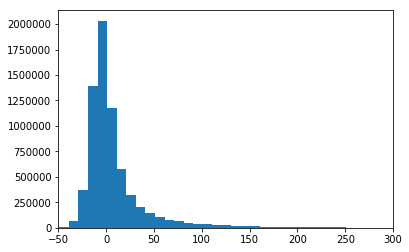

In [29]:
plt.hist(data=df, x="ArrDelay", bins=np.arange(df.ArrDelay.min(),df.ArrDelay.max()+10,10) )
plt.xlim(-50,300)

(-10, 50)

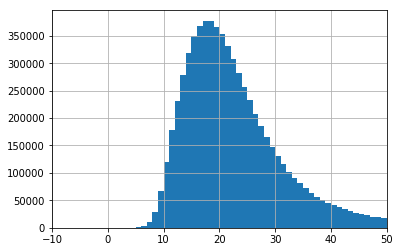

In [30]:
dff = df.ActualElapsedTime - df.AirTime
dff.hist(bins = np.arange(-200,200,1))
plt.xlim(-10,50)

> The initial plot of ArrDelay features show some immediate points of attention.
The most bins are set to the left of the axis, suggesting some strong outliers on the right. 
Also histgram suggests that there are delalys whose minutes are negative, which means the plane arrived ahead. 
However, it is unnatural that airplane arrives much earlier than expected.
They are worth taking a look bit of time to identify outliers and reasons to see if they need to be dealt with.

In [ ]:
df[(df.ArrDelay < -30)].ArrDelay.hist(bins =np.arange(df.ArrDelay.min(), df.ArrDelay.max()+1,1))
plt.xlim([df.ArrDelay.min(),-30])

In [ ]:
df[(df.ArrDelay < -90)]

In [ ]:
df[(df.ArrDelay > 400)]

What I hava

In [ ]:
plt.hist(data=df, x="Distance", bins=np.arange(0, df.Distance.max()+100,100));

In [ ]:
df[df.Distance< 100]

In [ ]:
#Air time delayplt.
plt.hist(data=df[~df.AirTime.isnull()], x="AirTime", bins=np.arange(0, df.AirTime.max()+10, 10))
plt.xlabel("AirTime")


In [ ]:
df[df.AirTime < 5]
#df.info(null_counts=True)

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> To start off with, I want to look at the pairwise cprrelations present between featires in the data.

In [12]:
numeric_vars = ["ArrDelay","delay_elapsed","DepDelay","Distance","AirTime","CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay"]
categoric_var = []

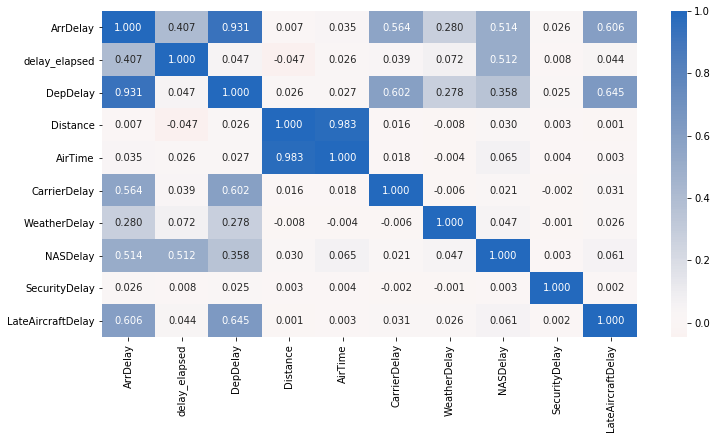

In [13]:
# correlation plot
plt.figure(figsize=[12,6])
sb.heatmap(df[numeric_vars].corr(), annot=True, fmt=".3f",
          cmap="vlag_r", center=0);

In [14]:
df.info(null_counts=True) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6855025 entries, 0 to 7009727
Data columns (total 28 columns):
Year                 6855025 non-null int64
Month                6855025 non-null int64
DayofMonth           6855025 non-null int64
DayOfWeek            6855025 non-null int64
DepTime              6855025 non-null object
CRSDepTime           6855025 non-null object
ArrTime              6855025 non-null object
CRSArrTime           6855025 non-null object
UniqueCarrier        6855025 non-null object
FlightNum            6855025 non-null int64
TailNum              6855020 non-null object
ActualElapsedTime    6855025 non-null float64
CRSElapsedTime       6855025 non-null float64
AirTime              6855025 non-null float64
ArrDelay             6855025 non-null float64
DepDelay             6855025 non-null float64
Origin               6855025 non-null object
Dest                 6855025 non-null object
Distance             6855025 non-null int64
TaxiIn               6855025 non-

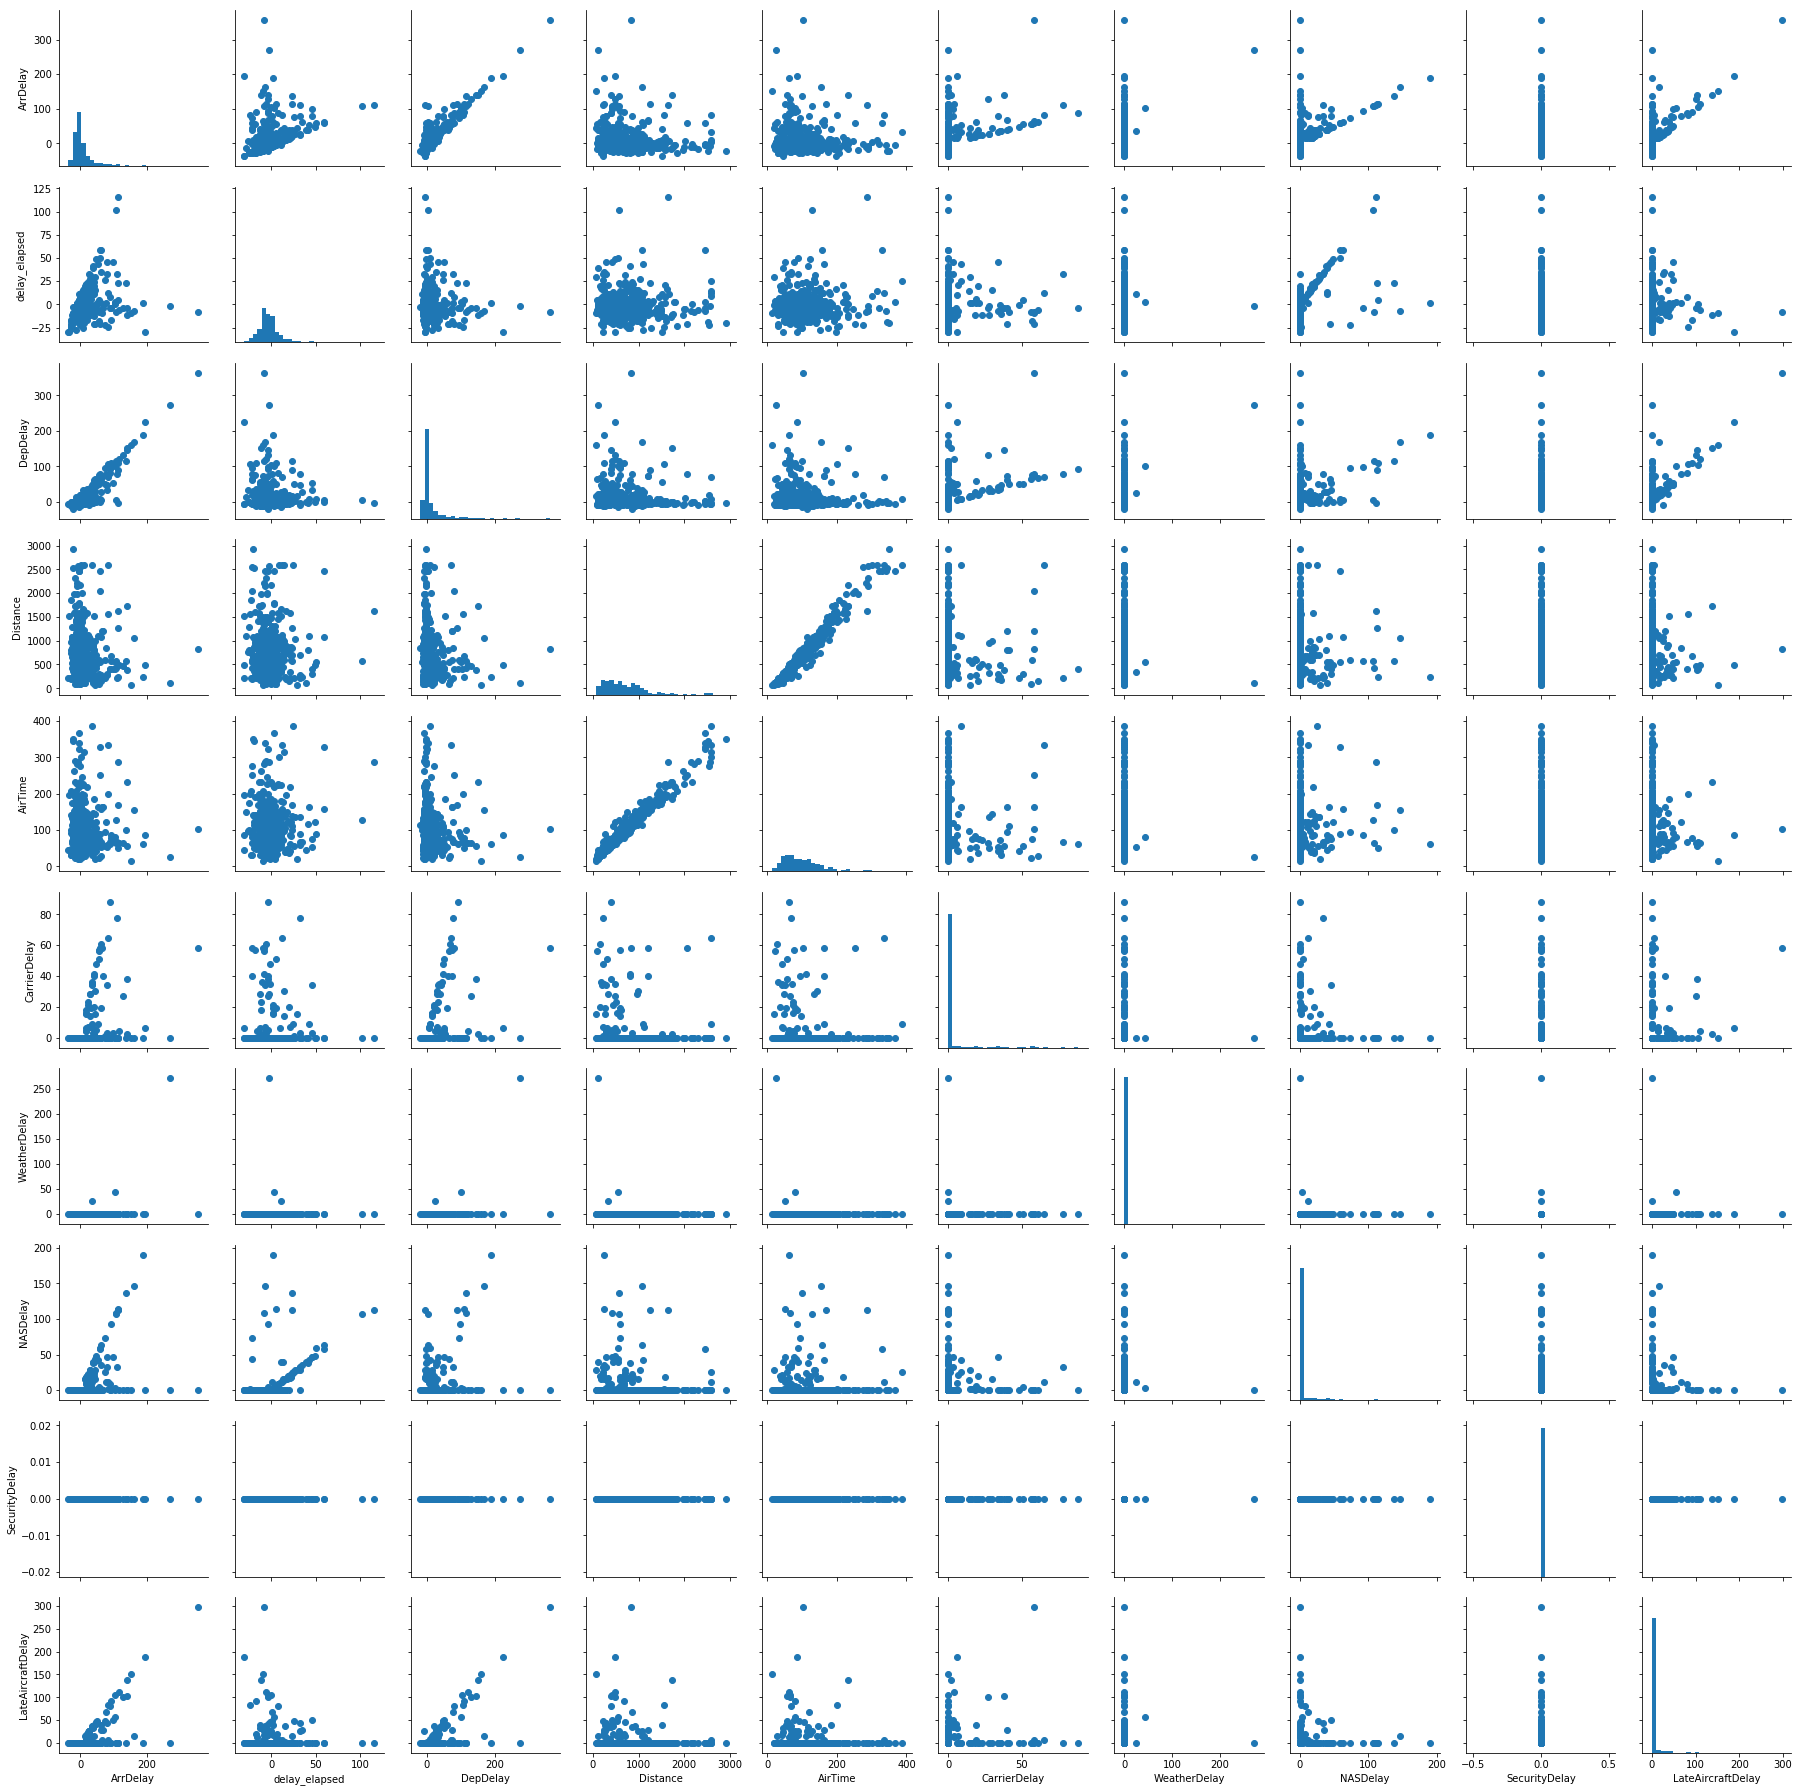

In [23]:
# plot matrix : sample 1000 flight data so that plots are clearer and they render faster
samples = np.random.choice(df.shape[0], 500, replace=False)
df_sample = df.iloc[samples,:]

g = sb.PairGrid(data=df_sample, vars=numeric_vars)
g = g.map_diag(plt.hist, bins = 30);
g.map_offdiag(plt.scatter);

In [ ]:
plt.hist(df.SecurityDelay)

In [ ]:
plt.scatter(data=df, x="Distance", y="AirTime", alpha=0.1, s=10);

### 

In [ ]:
plt.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!